In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Load epidemic italian data

In [2]:
from src.load_data import get_epidemic_data

In [3]:
df_epidemic = get_epidemic_data('Italy')

# the epidemic in Italy started on the 23th of February 2020
df_epidemic = df_epidemic[df_epidemic.index >= '2020-02-23']

df_epidemic.head()

Total cases  Active infected  Total deaths  Total recovered  \
2020-02-23        155.0            150.0           3.0              2.0   
2020-02-24        229.0            221.0           7.0              1.0   
2020-02-25        322.0            311.0          10.0              1.0   
2020-02-26        453.0            438.0          12.0              3.0   
2020-02-27        655.0            593.0          17.0             45.0   

            Daily cases (avg 7 days)  Daily deaths (avg 7 days)  
2020-02-23                      21.7                        0.4  
2020-02-24                      32.3                        1.0  
2020-02-25                      45.6                        1.4  
2020-02-26                      64.3                        1.7  
2020-02-27                      93.1                        2.4

# Fit the epidemiological model with ABC

In [4]:
from src.epi_model import SIR2
from src.optimizer import fit_model
from src.optimizer import compute_error


import pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import tempfile


In [5]:
# Wrapper functions for pyABC. Just changed input and data format!

def SIR2_abc(parameters, N=60*10**6, vacc_eff=0,vacc_speed=0,t0=0,I0=1,R0=0,V0=0,vacc_custom=False,t=np.arange(0,365)):
    beta = parameters['beta']
    gamma = parameters['gamma']
    tau = parameters['tau']
    
    r = SIR2(N,beta,gamma,tau,vacc_eff,vacc_speed,t0,I0,R0,V0,vacc_custom)
    
    return {'t': r[0], 
            'S': r[1], 
            'I': r[2], 
            'R': r[3],
            'V': r[4]}


def compute_error_abc(simulation, data):
    y_pred = [simulation['S'], simulation['I'], simulation['R']] 
    y_true = [60*10**6-data['S'], data['I'], data['R']]
    mse = compute_error(y_true,y_pred,which_error='perc')

    return mse 


In [6]:
# We want to fit the 1st wave in Italy, therefore tmax=120 (5 months since the beginning)

tmax = 150

# true data
ydata_cases = np.array(df_epidemic['Total cases'])[0:tmax]
ydata_inf = np.array(df_epidemic['Active infected'])[0:tmax]
ydata_rec = (np.array(df_epidemic['Total recovered'])+np.array(df_epidemic['Total deaths']))[0:tmax]

 
inhabitants_italy = 60*10**6

In [7]:
parameters_prior = Distribution(beta=RV("uniform", 0, 1),
                                gamma=RV("uniform", 0, 1),
                                tau = RV("uniform", 0, 60))

abc = ABCSMC(models=SIR2_abc,
             parameter_priors=parameters_prior,
             distance_function=compute_error_abc,
             population_size=1000)

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc.new(db_path, {"S": ydata_cases, 
                  "I": ydata_inf, 
                  "R": ydata_rec});

INFO:Sampler:Parallelizing the sampling on 12 cores.
INFO:History:Start <ABCSMC(id=44, start_time=2021-04-11 12:20:47.339410, end_time=None)>


In [8]:
h = abc.run(minimum_epsilon=15, max_nr_populations=20)


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 66.6632532836707
INFO:ABC:t: 0, eps: 66.6632532836707.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 66.5933721632546.
INFO:ABC:Acceptance rate: 1000 / 2254 = 4.4366e-01, ESS=9.1461e+02.
INFO:ABC:t: 2, eps: 66.45273577037956.
INFO:ABC:Acceptance rate: 1000 / 2269 = 4.4072e-01, ESS=8.4820e+02.
INFO:ABC:t: 3, eps: 65.68733267353163.
INFO:ABC:Acceptance rate: 1000 / 2347 = 4.2608e-01, ESS=8.1267e+02.
INFO:ABC:t: 4, eps: 61.79635114978255.
INFO:ABC:Acceptance rate: 1000 / 2426 = 4.1220e-01, ESS=8.6162e+02.
INFO:ABC:t: 5, eps: 54.313860545491536.
INFO:ABC:Acceptance rate: 1000 / 2464 = 4.0584e-01, ESS=8.4955e+02.
INFO:ABC:t: 6, eps: 47.39037815874408.
INFO:ABC:Acceptance rate: 1000 / 3427 = 2.9180e-01, ESS=7.8968e+02.
INFO:ABC:t: 7, eps: 44.302936242732315.
INFO:ABC:Acceptance rate: 1000 / 5066 = 1.9739e-01, ESS=7.3866e+02.
INFO:ABC:t: 8, eps: 41.12696349284202.
INFO:ABC:Accepta

In [9]:
results = pd.concat([h.get_distribution()[0].quantile(0.025), 
                     h.get_distribution()[0].mean(), 
                     h.get_distribution()[0].quantile(0.975)], axis=1)
results.columns = ["low", "mean", "high"]
results

low       mean       high
name                                  
beta    0.836709   0.921529   0.991054
gamma   0.026753   0.029640   0.032768
tau    13.503929  14.786671  16.618153

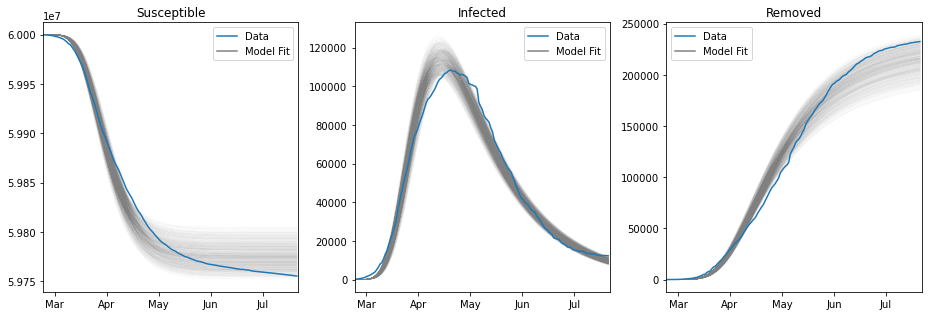

In [10]:

xlab = ['Mar','Apr','May','Jun','Jul','Ago','Sep']

def plot_fit(parameter, ax, alpha=0.1):
    def plot_data(sum_stat, weight, ax, parameter, **kwargs):
        """Plot a single trajectory"""
        ax.plot(np.arange(0,150), sum_stat[parameter][0:150], color='grey', alpha=alpha)

    ax = plot_data_callback(h, plot_data, ax=ax, parameter=parameter)

    if parameter == "S":
        ax = plt.plot(60*10**6-ydata_cases, color="C0", label='Data')
        ax = plt.title('Susceptible')
    elif parameter == "I":
        ax = plt.plot(ydata_inf, color="C0", label='Data')
        ax = plt.title('Infected')
    elif parameter == "R":
        ax = plt.plot(ydata_rec, color="C0", label='Data')
        ax = plt.title('Removed')

    ax = plt.xticks(np.arange(7,200,30.5),xlab)
    ax = plt.xlim(0,tmax)

    colors = ['C0', 'grey']
    lines = [Line2D([0], [0], color=c) for c in colors]
    labels = ['Data', 'Model Fit']
    ax = plt.legend(lines, labels)
    return ax

alpha = 0.005
fig = plt.figure(figsize=(13,4.5))
ax = plot_fit(parameter="S", ax=fig.add_subplot(131), alpha = alpha)
ax = plot_fit(parameter="I", ax=fig.add_subplot(132), alpha = alpha)
ax = plot_fit(parameter="R", ax=fig.add_subplot(133), alpha = alpha)
fig.tight_layout()
plt.savefig('results/abc_model_italy_1stwave.png',dpi=300)
plt.show()

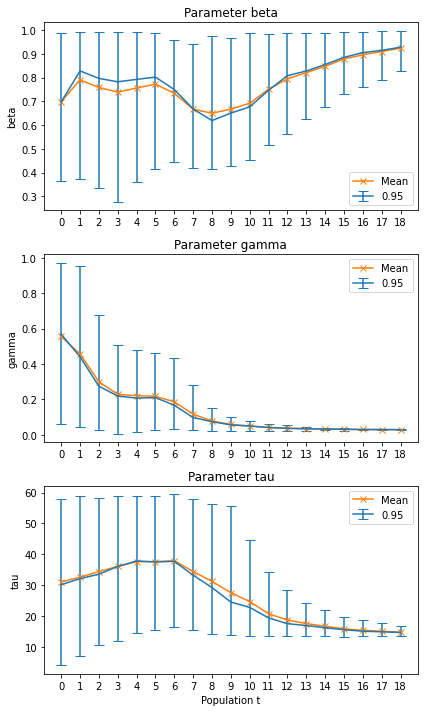

In [11]:
pyabc.visualization.plot_credible_intervals(
    h, levels=[0.95],
    show_mean=True,
    size=(6, 10))
plt.savefig('results/abc_model_italy_1stwave_ci.png',dpi=300)


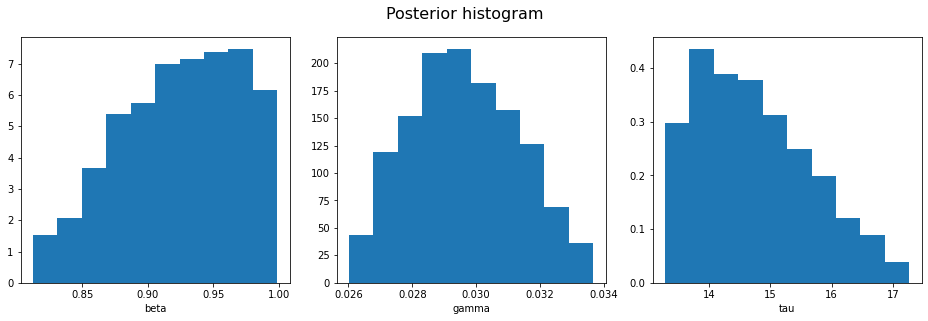

In [12]:
fig = plt.figure(figsize=(13,4.5))
fig.suptitle('Posterior histogram', fontsize=16)
ax = pyabc.visualization.plot_histogram_1d(h, x="beta", ax=fig.add_subplot(131))
ax = pyabc.visualization.plot_histogram_1d(h, x="gamma",  ax=fig.add_subplot(132))
ax = pyabc.visualization.plot_histogram_1d(h, x="tau", ax=fig.add_subplot(133))
fig.tight_layout()
plt.savefig('results/abc_model_italy_1stwave_posterior_histogram.png',dpi=300)

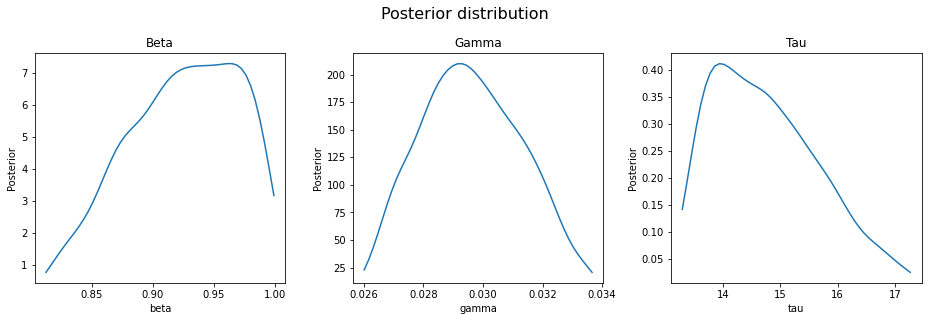

In [13]:
fig = plt.figure(figsize=(13,4.5))
fig.suptitle('Posterior distribution', fontsize=16)
ax = pyabc.visualization.plot_kde_1d_highlevel(h, x="beta", title="Beta", ax=fig.add_subplot(131))
ax = pyabc.visualization.plot_kde_1d_highlevel(h, x="gamma", title="Gamma", ax=fig.add_subplot(132))
ax = pyabc.visualization.plot_kde_1d_highlevel(h, x="tau", title="Tau", ax=fig.add_subplot(133))
fig.tight_layout()
plt.savefig('results/abc_model_italy_1stwave_posterior_distribution.png',dpi=300)

/Users/vincenzonardelli/anaconda3/envs/sichrd/lib/python3.7/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


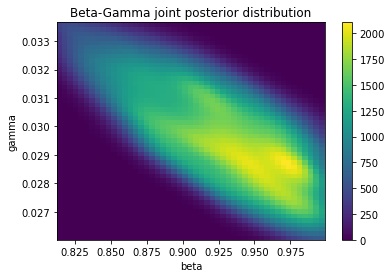

In [14]:
pyabc.visualization.plot_kde_2d_highlevel(h, x="beta", y="gamma", title="Beta-Gamma joint posterior distribution")
plt.savefig('results/abc_model_italy_1stwave_joint_posterior.png',dpi=300)

/Users/vincenzonardelli/anaconda3/envs/sichrd/lib/python3.7/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)
/Users/vincenzonardelli/anaconda3/envs/sichrd/lib/python3.7/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


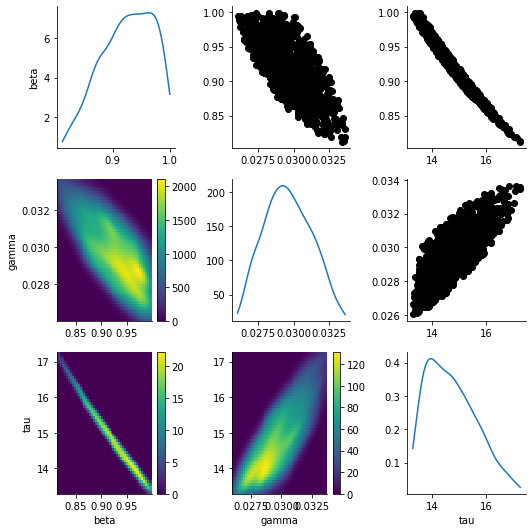

In [15]:
pyabc.visualization.plot_kde_matrix_highlevel(h)
plt.savefig('results/abc_model_italy_1stwave_matrix.png',dpi=300)